# Ajustar un modelo pre-entrenado para la clasifición de textos

Para hacer el algoritmo supervisado se usará un modelo pre-entrenado, en concreto BERT, pues es uno de los mas usados para trabajar con textos en ingles.

Tambien se hará un Fine-tuning para usar el modelo pre-entrenado y entrenarlo sobre el dataset.


Instalamos las librerías que vamos a necesitar:

# Cargando Librerias

In [1]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=2ca68a2113e9ce36fa2218f5b9580756142c923b7314d45f147b403731d70d70
  Stored in directory: /root/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Gen RAM Free: 12.3 GB  |     Proc size: 94.2 MB
GPU RAM Free: 15101MB | Used: 0MB | Util   0% | Total     15360MB


In [3]:
!pip install transformers datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.utils import pad_sequences 
import tensorflow as tf 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# asegurar que los experimentos se pueden reproducir
tf.random.set_seed(42)

tf.__version__

'2.12.0'

# Cargando Datos



In [5]:
from google.colab import drive
from datasets import load_dataset, DatasetDict
# mount your google drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/NLP/Proyecto/"
data_files = {"train": PATH+"data_train.csv"}

# probar cogiendo un 6%, coger train como 0.8 y el test en 0..2, despues dividir el test en 0.5
all_data = pd.read_csv(PATH+"data_train.csv")

val = load_dataset("csv", data_files=data_files, split = "train[:3%]")

dict_com = DatasetDict()
dict_com['validation'] = val
dict_com

aux_test = load_dataset("csv", data_files=data_files, split = "train[15%:20%]")
dict_com['test'] = aux_test

Mounted at /content/drive


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8d9bce8b1cd5692e/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


# Seleccionando la misma cantidad de Instancias para cada cateegoria

En el codigo anterior se trabajan con 30mil datos en el conjunto train, ahora trataremos de tener 6mil instancias de cada clase (5 clase) para tener los datos balanceados y ver si aprende mejor.

In [6]:
dict_com

DatasetDict({
    validation: Dataset({
        features: ['Title', 'Review', 'Polarity', 'Country', 'Type'],
        num_rows: 7551
    })
    test: Dataset({
        features: ['Title', 'Review', 'Polarity', 'Country', 'Type'],
        num_rows: 12585
    })
})

In [7]:
all_data

,Title,Review,Polarity,Country,Type
0,LINDA EXPERIENCIA,Hermoso lugar para admirar las obras de Botero...,5,Colombia,Attractive
1,Plaza típca,No puedes dejar pasar sus vistas y arquitectur...,5,Cuba,Attractive
2,Tres días en La Habana,Este es un hotel lleno de historia y carácter....,4,Cuba,Hotel
3,Recomendado,"Justo lo que buscaba. Sabores exoticos, buena ...",5,Colombia,Restaurant
4,Caro pero vale la pena,"La comida es muy buena, desde las entradas has...",4,Mexico,Restaurant
...,...,...,...,...,...
251691,Verdadera joya arquitectónica,"Es una construcción majestuosa, creo que de la...",5,Mexico,Attractive
251692,Romántico,Muy al estilo de Romeo y Julieta es este sitio...,5,Mexico,Attractive
251693,Parece un castillo,Ideal para subir las escalinatas y divisar su ...,5,Mexico,Attractive
251694,Imperdible,"Es imperdible, de ahí puedes ver muy bien la c...",5,Mexico,Attractive


In [8]:
label_1 = all_data[all_data["Polarity"] == 1]
label_2 = all_data[all_data["Polarity"] == 2]
label_3 = all_data[all_data["Polarity"] == 3]
label_4 = all_data[all_data["Polarity"] == 4]
label_5 = all_data[all_data["Polarity"] == 5]

print(label_1.shape)
print(label_2.shape)
print(label_3.shape)
print(label_4.shape)
print(label_5.shape)

(5772, 5)
(6952, 5)
(21654, 5)
(60225, 5)
(157093, 5)


In [9]:
frames = [label_1, label_2, label_3.head(6952), label_4.head(6952), label_5.head(6952)]
all_join = pd.concat(frames)
print(all_join.shape)
all_join.to_csv(PATH + 'all_data_train_polarity.csv', index=False, encoding='utf-8-sig')

(33580, 5)


In [10]:
frames = [label_1, label_2.head(5772), label_3.head(5772), label_4.head(5772), label_5.head(5772)]
all_join = pd.concat(frames)
all_join.to_csv(PATH + 'all_data_train_polarity.csv', index=False, encoding='utf-8-sig')

In [11]:
data_files = {"train": PATH+"all_data_train_polarity.csv"}
train = load_dataset("csv", data_files=data_files, split = "train[:100%]")

dict_com['train'] = train
dict_com

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f24eca9742495205/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


DatasetDict({
    validation: Dataset({
        features: ['Title', 'Review', 'Polarity', 'Country', 'Type'],
        num_rows: 7551
    })
    test: Dataset({
        features: ['Title', 'Review', 'Polarity', 'Country', 'Type'],
        num_rows: 12585
    })
    train: Dataset({
        features: ['Title', 'Review', 'Polarity', 'Country', 'Type'],
        num_rows: 28860
    })
})

# Codificación de las labels


Entrenamos un codificador con los valores del campo label. Lo que va a hacer es asignar a cada label un valor numérico:

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(dict_com['train']['Polarity'])
TARGET_LABELS = list(le.classes_)
NUM_LABELS = len(TARGET_LABELS)
NUM_LABELS

5

In [13]:
y = le.transform(dict_com['train']['Polarity'])

Borramos el campo **file**, **label** y **label_num**.
Volvemos a añadir el campo **label** pero ahora con los valores ya transformados para que sean desde 0 a 4

In [14]:
cleaned_dict = dict_com.remove_columns(['Title', 'Country', 'Type', 'Polarity'])
cleaned_dict

DatasetDict({
    validation: Dataset({
        features: ['Review'],
        num_rows: 7551
    })
    test: Dataset({
        features: ['Review'],
        num_rows: 12585
    })
    train: Dataset({
        features: ['Review'],
        num_rows: 28860
    })
})

El dataset contiene 2015 instancias para training.

**Debemos añadir de nuevo label pero ahora con los valores codificados (es decir, los valores que están en y)**

In [15]:
cleaned_dict['train'] = cleaned_dict['train'].add_column('label', y)
y = le.transform(dict_com['test']['Polarity'])
cleaned_dict['test'] = cleaned_dict['test'].add_column('label', y)
cleaned_dict

DatasetDict({
    validation: Dataset({
        features: ['Review'],
        num_rows: 7551
    })
    test: Dataset({
        features: ['Review', 'label'],
        num_rows: 12585
    })
    train: Dataset({
        features: ['Review', 'label'],
        num_rows: 28860
    })
})

# Tokenización

Debemos preparar los textos para que tener el formato necesario para la entrada del transformer. Para ello deberemos utilizar el tokenizador asociado al modelo que vayamos a utilizar. 
Algunos modelos ya tienen clases predefinida para su tokenizador y para tareas específias. Por ejemplo, para cargar el tokenizador de **BERT** es posible utilizar la clase **BertTokenizer**. HuggingFace proporciona una clase que te permite cargar cualquier tokenizador, indicando simplemente el nombre del modelo. Esta clase es **AutoTokenizer**.

En este notebook, vamos a utilizar el modelo **bert-base-uncased**. 

In [16]:
from transformers import AutoTokenizer
#model_name="xlm-roberta-base"
model_name = "finiteautomata/beto-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Vamos a aplicar el tokenizador a un texto:

In [17]:
sentence = cleaned_dict['train'][100]['Review']
print(sentence)
print()
encoding = tokenizer(sentence)
encoding

Habitaciones viejas, humedas, ruinosas y mal insonorizadas..limpieza: mal. Desayunos muy mal.personal dado a timarte con taxis, etc...



{'input_ids': [4, 18385, 1332, 16255, 1017, 12867, 1234, 1017, 2603, 3004, 1021, 1042, 1678, 2260, 2471, 18010, 1319, 1009, 1009, 9727, 1181, 1678, 1009, 1646, 1428, 6374, 30934, 1456, 1678, 1009, 2387, 3564, 1013, 13081, 3695, 1051, 11164, 30934, 1017, 4582, 1009, 1009, 1009, 5], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Necesitamos conocer la longitud máximas de las oraciones en el training. En función de esta longitud máxima, podemos establecer el parámetro **MAX_LENGTH** que usaremos para representar las oraciones de nuestro dataset. Todas las oraciones tendrán la misma longitud. 
Si la longitud máxima es superior a 512 tokens, la limitaremos a 512, porque el tamaño máximo que acepta el modelo BERT es 512.  

In [18]:
MAX_LENGTH= max([len(tokenizer(text).input_ids) for text in cleaned_dict['train']['Review']])
print("La longitud máxima de la secuencia es: ", MAX_LENGTH)

#Cambiar 512 por 150
# Probar con 70

MAX_LENGTH = min(70, MAX_LENGTH)
print("max_length", MAX_LENGTH)


Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors


La longitud máxima de la secuencia es:  3779
max_length 70


## Tokenizando los datos



In [19]:
def tokenize(examples):
    return tokenizer(examples["Review"], padding=True, truncation=True, max_length=MAX_LENGTH)


data_encodings=cleaned_dict.map(tokenize, batched=True)
data_encodings

Map:   0%|          | 0/7551 [00:00<?, ? examples/s]

Map:   0%|          | 0/12585 [00:00<?, ? examples/s]

Map:   0%|          | 0/28860 [00:00<?, ? examples/s]

DatasetDict({
    validation: Dataset({
        features: ['Review', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7551
    })
    test: Dataset({
        features: ['Review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12585
    })
    train: Dataset({
        features: ['Review', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 28860
    })
})

# Modelo 

Una vez preparados los textos. Se entrenara el modelo. Se usaran un modelo de Bert
  


In [20]:
from transformers import AutoModelForSequenceClassification

#TARGET_LABELS = dict_dataset['train'].features['label'].names
NUM_LABELS = len(TARGET_LABELS)

print('TARGET_LABELS:', TARGET_LABELS, 'num_labels:', NUM_LABELS )

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS,ignore_mismatched_sizes=True) 

TARGET_LABELS: [1, 2, 3, 4, 5] num_labels: 5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at finiteautomata/beto-sentiment-analysis and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Los vectores finales del modelo pre-entrenado BERT es sustituido por nuevo encabezado para la clasificación que ha sido inicializado aleatoriamente. Durante el entrenamiento, este vectores se ajustan para la tarea de clasificación, transfiriéndole el conocimiento del modelo pre-entrenado. entrenado.

#### Hyperparameteres

Necesitamos definir los hiperparámetros que se emplearán durante el proceso de entrenamiento. Algunos de estos hiperpárametros son el número de epochs para el entrenamiento, el tamaño del lote (batch), learning rate, etc.  Puedes experimentar con estos hiperparámetros para encontrar la configuración óptima para tu tarea. 

En nuestro caso, trabajaremos con los hipérparametros por defecto. Necesitamos crear un objeto de la clase TrainingArguments, que incluye todos los hiperparámetros (ya inicializados con valores por defecto) que puedes ajustar. 

In [21]:
from transformers import TrainingArguments
args = TrainingArguments(output_dir="./outputs")
# args

Vamos a modificar algunos de ellos, por ejemplo, el tamaño del batch tanto para training como para evaluación (de 8 a 32). Además, vamos a especificar la estrategia de evaluación a epoch para que nos proporcione los resultados después de cada epoch. 


In [22]:
args.evaluation_strategy="epoch"
args.per_device_train_batch_size = 16
args.per_device_eval_batch_size = 16


#### Métricas

También tenemos que definir el conjunto de métricas que se utilizaran para evaluar el modelo sobre el conjunto de validación. Este conjunto de métricas depende de cada tarea. En el caso de la clasificación de textos, además del accuracy, es interesante conocer la precisión, recall y f1. 

Vamos a definir una función que compute estas métricas. 


In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """recibe un lote prediciones inferidas por el modelo. """
    y_true = pred.label_ids # son las labels en el gold standard
    y_pred = pred.predictions.argmax(-1) # pred.predictions devuelve una lista con las predicciones
                                        # para casda clase. Debemos quedarnos con la de mayor probabilidad.

    # como son varias clases, utilizaremos la macro
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

#### Trainer

Ya estamos listos para entrenar el modelo. Para ello, Pytorch ya nos proporciona una clase **Trainer**,  que está optimizada para entrenar transformers, y que además nos va a ahorrar mucho trabajo (no será necesario escribir el ciclo de entrenamiento por epochs y calcular las métricas sobre el conjunto de validación). 

Para crear este objeto Trainer, deberemos pasarle el modelo, los argumentos, la función para compuar las métricas, y el conjunto de entrenamiento y validación.

In [24]:
from transformers import Trainer

trainer = Trainer(
    model=model,            # modelo que será ajustado
    args = args,     # hiperparámetros
    train_dataset=data_encodings['train'], # conjunto training
    eval_dataset=data_encodings['validation'],   # conjunto de validación
    compute_metrics=compute_metrics,    # función para computar las métricas
)

Por fin, podemos entrenar para ajustar el modelo a la tarea de clasificación de textos: 

In [25]:
#import torch
#torch.cuda.empty_cache()
#torch.cuda.memory_summary(device=None, abbreviated=False)

trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.042900,No log
2,0.836000,No log
3,0.526300,No log


TrainOutput(global_step=5412, training_loss=0.8141481916902688, metrics={'train_runtime': 1382.0804, 'train_samples_per_second': 62.645, 'train_steps_per_second': 3.916, 'total_flos': 3114558230893200.0, 'train_loss': 0.8141481916902688, 'epoch': 3.0})

Una vez finalizado el entrenamiento, es posible evaluar el modelo final sobre el conjunto de datos de validación. Las métricas obtenidas son: 

In [26]:
trainer.evaluate()

{'eval_runtime': 35.0051,
 'eval_samples_per_second': 215.711,
 'eval_steps_per_second': 13.484,
 'epoch': 3.0}

In [27]:
trainer.save_model( PATH + "berta_70_polarity_same_datas_twitter")

In [28]:
#model = AutoModelForSequenceClassification.from_pretrained(PATH + "berta_70", num_labels=NUM_LABELS) 

## Evaluación

Por último, vamos a utilizar el modelo para predecir las clases para textos que no han sido utilizados durane el entrenamiento. Es decir, vamos a aplicar el modelo sobre el conjunto test.

La siguiente función recibe un texto y devuelve la clase inferida por el modelo. La función codifica el texto usando el tokenizador y el modelo es aplicado sobre esta codificación. Sobre la salida del modelo, aplicaremos una función softmax, que calcule la probabilidad de cada clase. Finalmente, devolvemos la clase con mayor probabilidad (usaremos la función **argmax**)
 .


In [29]:
def get_prediction(text):
    # prepara el texto, aplicamos la misma tokenización que la utilizada en el training
    inputs = tokenizer(text, padding="max_length", truncation=True, return_tensors="pt").to("cuda")
    # aplicamos el modelo
    outputs = model(**inputs)
    # obtenemos la probabilidad para cada clase
    probs = outputs[0].softmax(1)
    # argmax nos devuelve la clase con mayor probabilidad.
    # argmax devuelve un tensor. Debemos devolver su valor asociado 
    return probs.argmax().item()

Vamos a aplicar la función **get_prediction** al conjunto de evaluación:

In [30]:
y_pred=[get_prediction(text) for text in cleaned_dict['test']['Review']]
y_test = cleaned_dict['test']['label']

Mostramos los resultados finales. 

In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       302
           1       0.50      0.87      0.64       321
           2       0.52      0.83      0.64      1088
           3       0.40      0.59      0.48      3098
           4       0.88      0.61      0.72      7776

    accuracy                           0.63     12585
   macro avg       0.62      0.74      0.66     12585
weighted avg       0.72      0.63      0.65     12585



(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

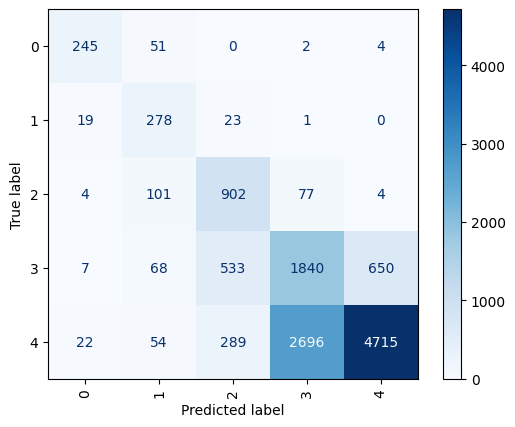

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.xticks(rotation=90)

Al usar el modelo pre-entrenado se obtiene una buena clasificación de los datos

# Datos test reales

In [35]:
df_train = pd.read_excel(PATH+"test.xlsx") 

In [36]:
df_train.to_csv(PATH + 'data_test.csv', index=False, encoding='utf-8-sig')

In [37]:
aux = load_dataset("csv", data_files=PATH + "data_test.csv", encoding='utf-8')

#y = le.transform(dict_com['test']['Polarity'])
print(aux)

cleaned_dict = aux.remove_columns(['Title', 'ID'])
cleaned_dict

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-256e2c5180a67c41/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'Title', 'Review'],
        num_rows: 107863
    })
})


DatasetDict({
    train: Dataset({
        features: ['Review'],
        num_rows: 107863
    })
})

In [38]:
y_pred=[get_prediction(text) for text in cleaned_dict['train']['Review']]
#y_test = cleaned_dict['test']['label']

#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot(cmap=plt.cm.Blues,values_format='g')
#plt.xticks(rotation=90)

In [39]:
df_train['polarity'] = y_pred
df_train.to_csv(PATH + 'data_polarity_same_clases_size_twitter.csv', index=False, encoding='utf-8-sig')